<a href="https://colab.research.google.com/github/ss-ghule/misc_or_test_repo/blob/master/anime_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [0]:
!mkdir anime_planet
!mkdir media_kitsu

In [0]:
!curl "https://media.kitsu.io/characters/images/[1000-2000]/original.jpg" -o "media_kitsu/#1.jpg"

In [0]:
!curl "https://www.anime-planet.com/images/characters/i-[1000-1500].jpg" -o "anime_planet/#1.jpg"

In [13]:
!ls

anime_planet		    list_attr_celeba.csv
celeba-dataset.zip	    list_bbox_celeba.csv
celeb_training_checkpoints  list_eval_partition.csv
celeb_training_images	    list_landmarks_align_celeba.csv
img_align_celeba	    media_kitsu
img_align_celeba.zip	    sample_data
kaggle.json


In [0]:
from IPython.display import display
from IPython.display import clear_output

In [0]:
from PIL import Image

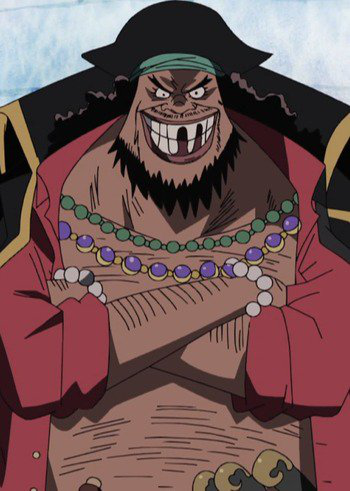

In [16]:
img=Image.open('anime_planet/998.jpg')
display(img)

In [17]:
!wget 'https://raw.githubusercontent.com/nagadomi/lbpcascade_animeface/master/lbpcascade_animeface.xml'

--2019-08-22 19:13:25--  https://raw.githubusercontent.com/nagadomi/lbpcascade_animeface/master/lbpcascade_animeface.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246945 (241K) [text/plain]
Saving to: ‘lbpcascade_animeface.xml’

lbpcascade_animefac 100%[===================>] 241.16K  --.-KB/s    in 0.03s   

2019-08-22 19:13:25 (8.29 MB/s) - ‘lbpcascade_animeface.xml’ saved [246945/246945]



# Prepare Data

In [0]:
import cv2
import os
from PIL import Image
from tqdm import tqdm

In [0]:
crop_size=(64,64)
only_color=True
faceCascade=cv2.CascadeClassifier('lbpcascade_animeface.xml')

In [0]:
def biggest_rectangle(r):
  return r[2]*r[3]

def extract_faces(data_dir,output_dir,prefix=''):
  for count,filename in enumerate(tqdm(os.listdir(data_dir))):
    image=cv2.imread(os.path.join(data_dir,filename))
    if image is not None:
      gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      gray=cv2.equalizeHist(gray)
      faces=faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.01,
                                         minNeighbors=5,
                                         minSize=(90,90))
      
      if len(faces)==0:
        continue
      elif len(faces)>1:
        sorted(faces,key=biggest_rectangle,reverse=True)

      if only_color and (Image.fromarray(image).convert('RGB').getcolors() is not None):
        continue
      x,y,w,h=faces[0]
      cropped_image=image[y:y+h,x:x+w,:]
      resized_image=cv2.resize(cropped_image,crop_size)
      cv2.imwrite(os.path.join(output_dir,str(count)+'_'+prefix+'.png'),resized_image)

In [21]:
!mkdir faces
!ls

anime_planet		    lbpcascade_animeface.xml
celeba-dataset.zip	    list_attr_celeba.csv
celeb_training_checkpoints  list_bbox_celeba.csv
celeb_training_images	    list_eval_partition.csv
faces			    list_landmarks_align_celeba.csv
img_align_celeba	    media_kitsu
img_align_celeba.zip	    sample_data
kaggle.json


In [22]:
#media-kitsu
data_dir='media_kitsu'
output_dir='faces'
prefix='mk'
extract_faces(data_dir,output_dir,prefix)

100%|██████████| 2001/2001 [01:12<00:00, 27.72it/s]


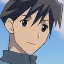

In [26]:
display(Image.open('faces/2_mk.png'))

In [27]:
data_dir='anime_planet'
output_dir='faces'
prefix='ap'
extract_faces(data_dir,output_dir,prefix)

100%|██████████| 2501/2501 [01:56<00:00, 21.56it/s]


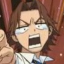

In [28]:
display(Image.open('faces/928_ap.png'))

# GANs

In [29]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [31]:
tf.__version__

'2.0.0-beta1'

In [0]:
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

## Create Dataset

In [33]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [34]:
type(train_images)

numpy.ndarray

In [35]:
num_of_faces=len(os.listdir('faces'))
print(num_of_faces)

2122


In [0]:
train_data_dim=(num_of_faces,64,64,3)

In [0]:
def norm_img(img):
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    img = (img + 1) * 127.5
    return tf.cast(img,tf.uint8) 

In [0]:
def create_train_data(img_dir,dim):
  data=np.empty(dim,dtype=np.float32)
  for index,img_file_name in enumerate(os.listdir(img_dir)):
    img=Image.open(os.path.join(img_dir,img_file_name))
    img=np.asarray(img)
    data[index]=norm_img(img)
  return data

In [0]:
train_images=create_train_data('faces',train_data_dim)

In [40]:
train_images.shape

(2122, 64, 64, 3)

In [41]:
print(train_images.min())
print(train_images.max())

-1.0
1.0


In [0]:
#normalize images
#train_images=(train_images-127.5)/127.5
#train_images=train_images/255

W0822 19:18:09.446092 139989496469376 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


262


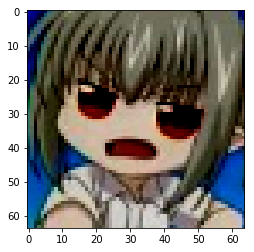

In [43]:
num=np.random.randint(0,num_of_faces)
print(num)
plt.imshow(train_images[num])

In [0]:
train_images=train_images.reshape(train_images.shape[0],64,64,3)

In [0]:
BUFFER_SIZE=1000
BATCH_SIZE=256

In [0]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8,8,256)))
  
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape == (None, 64, 64, 3)

  return model

W0822 19:18:14.264425 139989496469376 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.031124538
0.029936071


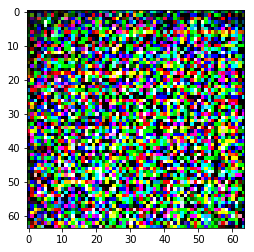

In [48]:
generator=make_generator_model()

noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
print(np.min(generated_image))
print(np.max(generated_image))
plt.imshow(generated_image[0]*255)

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [50]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.00014289]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [0]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [0]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir='./anime_gan_training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

## Define the training loop

In [0]:
EPOCHS=5
noise_dim=100
num_examples_to_generate=16

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [0]:
@tf.function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)
    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)

  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [0]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()

    for image_batch in dataset:
      train_step(image_batch)

    clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

  clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [0]:
!mkdir anime_training_images

In [0]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(8,8))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    #plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    #plt.imshow(predictions[i,:,:,2]*255,cmap='gray')
    plt.imshow(denorm_img(predictions[i]))
    plt.axis('off')

  plt.savefig('anime_training_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
%%time
EPOCHS=10000
train(train_dataset,EPOCHS)

Buffered data was truncated after reaching the output size limit.